# Text Mining Example : Sentiment Classification

In [44]:
import pandas as pd
import os
import  re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import  PorterStemmer
import numpy as  np

## Loading data


In [5]:
main_path = os.getcwd()

test_path_positive  = os.path.join(main_path,r"aclImdb/test/pos" ) 
test_path_negative  = os.path.join(main_path,r"aclImdb/test/neg" ) 

train_path_positive  = os.path.join(main_path,r"aclImdb/train/pos" ) 
train_path_negative  = os.path.join(main_path,r"aclImdb/train/neg" ) 

In [6]:
#test
temp = os.listdir(test_path_positive)
temp =  [ os.path.join(test_path_positive,  t) for t in temp]
files_test =  temp

temp = os.listdir(test_path_negative)
temp =  [ os.path.join(test_path_negative,  t) for t in temp]

files_test.extend(temp)

dict_test = {"id":[], "rating":[], "review":[]}

#train

temp = os.listdir(train_path_positive)
temp =  [ os.path.join(train_path_positive,  t) for t in temp]
files_train =  temp

temp = os.listdir(train_path_negative)
temp =  [ os.path.join(train_path_negative,  t) for t in temp]

files_train.extend(temp)

dict_train = {"id":[], "rating":[], "review":[]}


In [7]:
for j in files_test:
    #print j
    with open(j, 'r') as f:
        temp_string = f.read()
        file_name = re.sub(r".+/", "", f.name)
    dict_test["id"].append(file_name.split("_")[0])
    dict_test["rating"].append(file_name.split("_")[1].split(".")[0])
    dict_test["review"].append(temp_string.decode("latin1",errors="ignore"))
    
    

In [8]:
for j in files_train:
    #print j
    with open(j, 'r') as f:
        temp_string = f.read()
        file_name = re.sub(r".+/", "", f.name)
    dict_train["id"].append(file_name.split("_")[0])
    dict_train["rating"].append(file_name.split("_")[1].split(".")[0])
    dict_train["review"].append(temp_string.decode("latin1",errors="ignore"))
    

In [9]:
df_train = pd.DataFrame(dict_train)
df_test  = pd.DataFrame(dict_test)

In [10]:
df_train.shape

(25000, 3)

In [11]:
df_test.shape

(25000, 3)

In [12]:
df_test.review.head()

0    Screenwriters Peter Viertel, Joan Harrison, an...
1    This was a very funny movie, not Oscar-worthy,...
2    I just want to comment to the woman above, tha...
3    This is a absolutely masterful stroke of geniu...
4    I saw this years ago, and it's entertaining, b...
Name: review, dtype: object

# Processing Text

Steeming, tokenize, filtering words that are very short

In [13]:

lemmatizer =  WordNetLemmatizer()
stemmer =  PorterStemmer()
# df_test.review.head().apply(  nltk.word_tokenize).apply(lambda x: [lemmatizer.lemmatize(j) for j in x  if len(j)>4])
df_test["review_pr"]  =  df_test.review.astype(unicode).str.replace("[^a-zA-Z ]", "").apply(  nltk.word_tokenize).apply(lambda x: [stemmer.stem(j) for j in x  if len(j)>=3]).apply(lambda x : " ".join(x))
df_train["review_pr"] = df_train.review.astype(unicode).str.replace("[^a-zA-Z ]", "").apply(  nltk.word_tokenize).apply(lambda x: [stemmer.stem(j) for j in x  if len(j)>=3]).apply(lambda x : " ".join(x))



In [14]:
df_test.review_pr.head()

0    screenwrit peter viertel joan harrison and all...
1    thi wa veri funni movi not oscarworthi but def...
2    just want comment the woman abov that the movi...
3    thi absolut master stroke geniu paul thoma and...
4    saw thi year ago and it entertain but not prof...
Name: review_pr, dtype: object

# Bag of Words


In [35]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=400,max_df=10000, ngram_range=(1,2), stop_words="english")
X_train =  vectorizer.fit_transform(df_train.review_pr)



In [45]:
y_train = np.where(df_train.rating.astype(int)<=5,0,1)
X_train.shape


(25000, 1077)

# Training model ()

In [50]:
from sklearn.model_selection import train_test_split


X_train_train , X_train_test, y_train_train, y_train_test= train_test_split(X_train, y_train )

In [55]:
X_train_train.shape , X_train_test.shape, y_train_train.shape, y_train_test.shape

((18750, 1077), (6250, 1077), (18750,), (6250,))

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {"n_estimators":[50,100], "max_features":[0.1,0.2, 0.5]}
parameters = {"n_estimators":[50], "max_features":[0.1]}



rf_cv = GridSearchCV(rf, cv=4, param_grid=parameters,  scoring="accuracy")

rf_cv.fit(X_train_train, y_train_train)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50], 'max_features': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

# Train Test Score

In [65]:
from sklearn.metrics import accuracy_score


accuracy_score( y_train_test,   rf_cv.predict(X_train_test))

0.8

# Feature Importance (first 30)

''

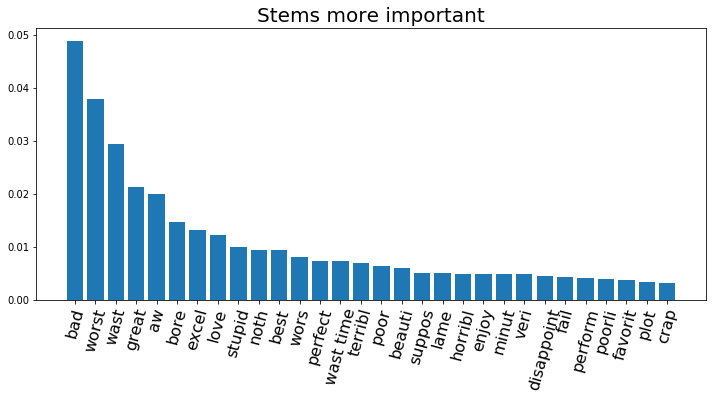

In [86]:
features =   pd.Series(rf_cv.best_estimator_.feature_importances_, index= vectorizer.get_feature_names()).sort_values(ascending=False)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 5))
plt.bar(features.index[0:30],  features[0:30])
plt.xticks(rotation=75)
plt.xticks(size=16)

plt.title("Stems more important", size=20)
;